In [1]:
import numpy as np
import mne
import os

In [2]:
import io
from copy import copy
from collections import OrderedDict
import requests


In [3]:
from hypyp import prep 
from hypyp import analyses
from hypyp import stats
from hypyp import viz

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from hypyp.ext.mpl3d import glm
from hypyp.ext.mpl3d.mesh import Mesh
from hypyp.ext.mpl3d.camera import Camera

In [5]:

path_1 = "./DCARE_02_sub1.snirf"
path_2 = "./DCARE_02_sub2.snirf"
data_1 = mne.io.read_raw_snirf(path_1, optode_frame='unknown', preload=False, verbose='warning')
data_2 = mne.io.read_raw_snirf(path_2, optode_frame='unknown', preload=False, verbose='warning')

In [6]:
names_epo1 = np.array([ch['ch_name'] for ch in data_1.info['chs']])
names_epo2 = np.array([ch['ch_name'] for ch in data_2.info['chs']])

In [7]:
D_list_37 = ['D3', 'D5', 'D7']
D_list_48 = ['D4','D6', 'D8']

epo_ref1 = data_1.copy()
for idx in range(len(names_epo1)):
  aux_name = names_epo1[idx]
  for d in D_list_37:
    if d in aux_name:
      aux_list = list(aux_name)
      ind = aux_name.index(d)
      aux_list[ind+1] = '1'
      str_back = "".join(aux_list)
      mne.rename_channels(epo_ref1.info, {names_epo1[idx]:str_back})
    else:
      pass
  for d in D_list_48:
    if d in aux_name:
      aux_list = list(aux_name)
      ind = aux_name.index(d)
      aux_list[ind+1] = '2'
      str_back = "".join(aux_list)
      mne.rename_channels(epo_ref1.info, {names_epo1[idx]:str_back})
    else:
      pass

In [8]:
epo_ref2 = data_2.copy()
for idx in range(len(names_epo2)):
  aux_name = names_epo2[idx]
  for d in D_list_37:
    if d in aux_name:
      aux_list = list(aux_name)
      ind = aux_name.index(d)
      aux_list[ind+1] = '1'
      str_back = "".join(aux_list)
      mne.rename_channels(epo_ref2.info, {names_epo2[idx]:str_back})
    else:
      pass
  for d in D_list_48:
    if d in aux_name:
      aux_list = list(aux_name)
      ind = aux_name.index(d)
      aux_list[ind+1] = '2'
      str_back = "".join(aux_list)
      mne.rename_channels(epo_ref2.info, {names_epo2[idx]:str_back})
    else:
      pass

In [9]:
event1 = mne.events_from_annotations(epo_ref1)
events1 = event1[0]
events1id = event1[1]
type(events1id)

event2 = mne.events_from_annotations(epo_ref2)
events2 = event2[0]
events2id = event2[1]
type(events2id)

Used Annotations descriptions: ['1', '2', '3', '4', '5']
Used Annotations descriptions: ['1', '2', '3', '4', '5']


dict

In [10]:
epo_1 = mne.Epochs(epo_ref1, events1, events1id['3'], tmin=-0.1, tmax=120,
                    baseline=(None, 0), preload=True, event_repeated='merge')

Not setting metadata
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
3 matching events found
Setting baseline interval to [-0.128, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3 events and 940 original time points ...
0 bad epochs dropped


In [11]:
epo_2 = mne.Epochs(epo_ref2, events1, events1id['3'], tmin=-0.1, tmax=120,
                    baseline=(None, 0), preload=True, event_repeated='merge')

Not setting metadata
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
3 matching events found
Setting baseline interval to [-0.128, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3 events and 940 original time points ...
0 bad epochs dropped


In [12]:
mne.epochs.equalize_epoch_counts([epo_1, epo_2])

Dropped 0 epochs: 
Dropped 0 epochs: 


In [13]:
sampling_rate = epo_2.info['sfreq']
sampling_rate

7.8125

In [14]:
import matplotlib

import matplotlib.pyplot as plt

import mne

import numpy as np

import sys

from typing import Union

if not sys.warnoptions:
    import warnings
    warnings.filterwarnings("ignore")
    
def xwt(sig1: mne.Epochs, sig2: mne.Epochs, sfreq: Union[int, float], 
        freqs: Union[int, np.ndarray]) -> np.ndarray:
    """
    Perfroms a cross wavelet transform on two signals.
    Arguments:
        sig1: signal (eg. EEG data) of first participant
        sig2: signal (eg. EEG data) of second participant
        sfreq: sampling frequency of the data
        freqs: range of frequencies of interest in Hz
    Note:
        This function relies on MNE's mne.time_frequency.morlet
        and mne.time_frequency.tfr.cwt functions.
    Returns:
        (cross_sigs): the crosswavelet transform results
    """
    # Set the mother wavelet
    Ws = mne.time_frequency.tfr.morlet(sfreq, freqs, n_cycles=6.0, sigma=None,
                                       zero_mean=True)

    # Set parameters for the output
    n_freqs = len(freqs)
    n_epochs, n_chans, n_samples = sig1.get_data().shape
    cross_sigs = np.zeros(
        (n_chans, n_epochs, n_freqs, n_samples),
        dtype=complex) * np.nan

    # perform a continuous wavelet transform on all epochs of each signal
    for ind, ch_label in enumerate(sig1.ch_names):

        # Check the channels are the same between participants
        assert sig2.ch_names[ind] == ch_label

        # Extract the channel's data for both participants and apply cwt
        cur_sig1 = np.squeeze(sig1.get_data(mne.pick_channels(sig1.ch_names,
                                                              [ch_label])))
        tfr_cwt1 = mne.time_frequency.tfr.cwt(cur_sig1, Ws, use_fft=True,
                                              mode='same', decim=1)

        cur_sig2 = np.squeeze(sig2.get_data(mne.pick_channels(sig2.ch_names,
                                                              [ch_label])))
        tfr_cwt2 = mne.time_frequency.tfr.cwt(cur_sig2, Ws, use_fft=True,
                                              mode='same', decim=1)

        # Perfrom the cross wavelet transform
        cross_sigs[ind, :, :, :] = (tfr_cwt1 * tfr_cwt2.conj())
    return (cross_sigs)


def half_wave(sfreq: Union[int, float], freqs: Union[int, np.ndarray], n_cycles: int = 6.0,
              sigma: float = None, zero_mean: bool = True) -> tuple:
    """
    Calculates the minimum and maximum half-wavelength of each wavelet, so
    that the area outside of the cone of influence is excluded
    due to the edge effects created by zero padding.
    Arguments:
        sfreq: sampling frequency
        freqs: ranges of frequencies of interest in Hz
        n_cycles: number of cycles of the morelet wavelet (default is 6.0)
        sigma: Controls the width of the wavelet (i.e. temporal resolution.)
        If sigma is None the temporal resolution is adapted with the frequency
        like for all wavelet transform.
        The higher the frequency the shorter is the wavelet.
        If sigma is fixed the temporal resolution is fixed
        like for the short time Fourier transform
        and the number of oscillations
        increases with the frequency (default is None).
        zero_mean: If True, the wavelet has a mean of zero (default is True)
    Note:
        This function relies on MNE's mne.time_frequency.morlet function.
     Returns:
        max_half_wave, min_half_wave: The maximum and minimum half wave lengths
        that specify the bounds of the cone of influence
    """
    Wave = mne.time_frequency.tfr.morlet(sfreq, freqs, n_cycles,
                                         sigma, zero_mean)

    min_half_wave = []
    max_half_wave = []

    for number in Wave:
        min_half_wave.append(len(number) / 2)

    for wl in min_half_wave:
        max_wl = sfreq - wl
        max_half_wave.append(max_wl)

    return min_half_wave, max_half_wave



def plot_xwt(xwt_result: np.ndarray, sfreq: Union[int, float], freqs: Union[int, float, np.ndarray],
             time: int, time_conv: int, figsize: tuple, xmin: int,
             x_units: Union[int, float], y_units: Union[int, float]):
    """
    Plot the results of the Cross wavelet analysis.
    Arguments:
        xwt_result: results of the crosswavelet transform (xwt)
        sfreq: sampling frequency
        freqs: frequency range of interest in Hz
        time: time of sample duration in seconds
        time_conv: time conversion (default is 1000 so time is converted to ms)
        figsize: figure size (default is (30, 8))
        xmin: minimum x-value (default is 0)
        x_units: distance between xticks on x-axis (time) (default is 100)
        y_units: distance between yticks on y-axis (default is 5)
    Note:
        This function is not meant to be called indepedently,
        but is meant to be called when using plot_xwt_crosspower
        or plot_xwt_phase_angle.
    Returns:
    Figure of xwt results
    """
    dt = (time / sfreq) * time_conv

    min_half_wave, max_half_wave = half_wave(sfreq, freqs)

    #xmax = len(xwt_result[0, :])
    xmax = time
    #xmax_labels = time *time_conv #for fNIRS only
    #xmax_conv = time * time_conv
    #x_units_unconv = xmax * x_units #fnirs
    xticks = np.arange(xmin, xmax, x_units)
    x_labels = np.arange(xmin, xmax, x_units)

    data = xwt_result
    my_cm = matplotlib.cm.get_cmap()
    normed_data = (data - np.min(data)) / (np.max(data) - np.min(data))
    mapped_data = my_cm(normed_data)
    

    fig = plt.figure(figsize=figsize)
    plt.subplot(122)
    plt.imshow(mapped_data, aspect='auto', interpolation='lanczos')
    plt.gca().invert_yaxis()
    #plt.plot(min_half_wave, np.flip(freqs), color='c')
    #plt.plot(max_half_wave, np.flip(freqs), color='c')
    plt.ylabel('Frequencies (Hz)')
    plt.xlabel('Time (ms)')
    ylabels = np.arange(freqs[0], freqs[-1], y_units)
    plt.gca().set_yticks(ticks=np.linspace(0, len(freqs), len(ylabels)),
                         labels=[str(round(ylabel, 3)) for ylabel in ylabels if ylabel!=''])
    plt.gca().set_xticks(ticks = xticks, labels=x_labels)
    #plt.gca().set_xticklabels(labels=xticks)
    plt.xlim(xmin, xmax)
    plt.ylim(min(freqs), int(len(ylabels)))
    #plt.ylim(min(freqs), freqs[-1])

    plt.cm.get_cmap(my_cm)

    #plt.fill_between(min_half_wave, list(np.arange(len(min_half_wave), xmin, -1)),
                     #np.max(list(np.arange(xmin, len(min_half_wave)))), color='c')
    #plt.fill_between(max_half_wave, list(np.arange(len(max_half_wave), xmin, -1)),
                     #np.max(list(np.arange(xmin, len(min_half_wave)))), color='c')
    #plt.fill_betweenx
    #plt.axvspan(xmin, min(min_half_wave), color='c')
    #plt.axvspan(max(max_half_wave), xmax, color='c')

    return fig


def plot_xwt_crosspower(sig1: mne.Epochs, sig2: mne.Epochs, sfreq: Union[int, float],
                        freqs: Union[int, float, np.ndarray], time: int,
                        time_conv: int = 1000, figsize: tuple = (30, 8),
                        xmin: int = 0, x_units: Union[int, float] = 100, y_units: Union[int, float] = 5):
    """
    Plots cross wavelet crosspower results.
    Arugments:
        sig1: neural data signal of participant 1
        sig2: neural data signal of participant 2
        sfreq: sampling frequency of the data in Hz
        freqs: frequency range of interest in Hz
        time: time of sample duration in seconds
        time_conv: time conversion (default is 1000 so time is converted to ms)
        figsize: figure size (default is (30, 8))
        xmin: minimum x-value (default is 0)
        x_units: distance between xticks on x-axis (default is 100)
        y_units: distance between yticks on y-axis (default is 5)
    Returns:
        Figure of xwt crosspower results
    """

    result = xwt(sig1, sig2, sfreq, freqs)
    data = np.abs(np.squeeze(np.mean(result[0, :, :, :], 0)))
    fig = plot_xwt(data, sfreq, freqs, time, time_conv, figsize, xmin,
                   x_units, y_units)
    plt.title('Cross Wavelet Transform (Crosspower)')
    plt.colorbar(label='crosspower')

    return fig


def plot_xwt_phase_angle(sig1: mne.Epochs, sig2: mne.Epochs, sfreq: Union[int, float],
                         freqs: Union[int, float, np.ndarray], time: int,
                         time_conv: int = 1000, figsize: tuple = (30, 8),
                         xmin: int = 0, x_units: Union[int, float] = 100, y_units: Union[int, float] = 5):
    """
    Plots crosswavelet phase angle results.
    Arugments:
        sig1: neural data signal of participant 1
        sig2: neural data signal of participant 2
        sfreq: sampling frequency of the data in Hz
        freqs: frequency range of interest in Hz
        time: time of sample duration in seconds
        time_conv: time conversion (default is 1000 so time is converted to ms)
        figsize: figure size (default is (30, 8)
        xmin: minimum x-value (default is 0)
        x_units: distance between xticks on x-axis (default is 100)
        y_units: distance between ticks on y-axis (default is 5)
    Returns:
        Figure of xwt phase angle results
    """
    result = xwt(sig1, sig2, sfreq, freqs)
    data = np.angle(np.squeeze(np.mean(result[0, :, :, :], 0)))
    fig = plot_xwt(data, sfreq, freqs, time, time_conv, figsize, xmin,
                   x_units, y_units)
    plt.title('Cross Wavelet Transform (Phase Angle)')
    plt.colorbar(label='phase difference')

    return fig

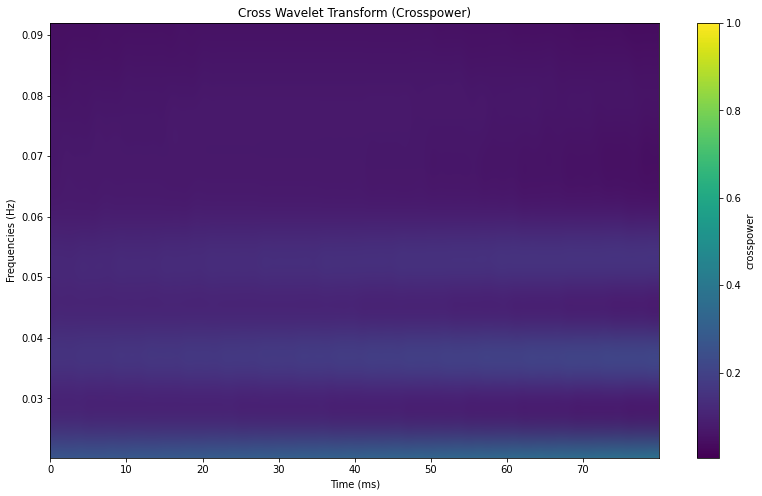

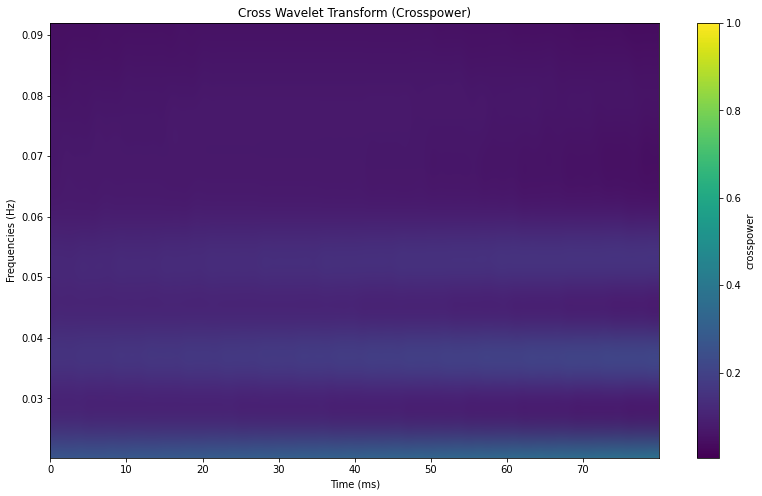

In [15]:
plot_xwt_crosspower(epo_1, epo_2, sfreq= 7.8125, freqs = np.arange(2, 12)/100., time=80,
                        time_conv = 1, xmin = 0, x_units = 10, y_units = 0.01)

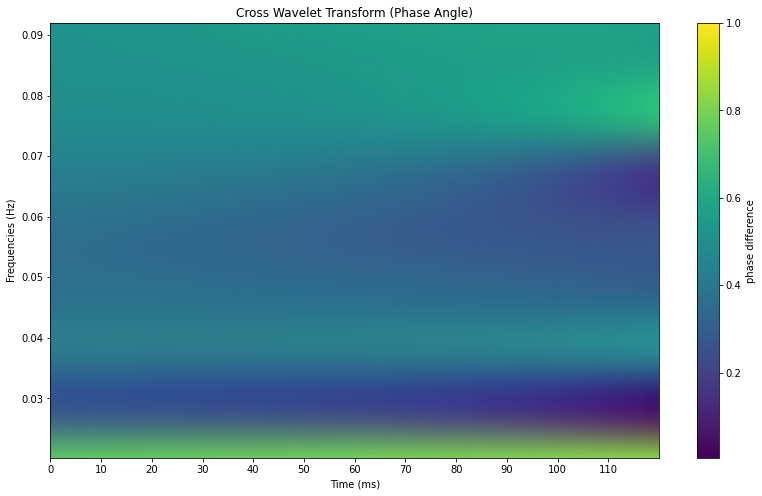

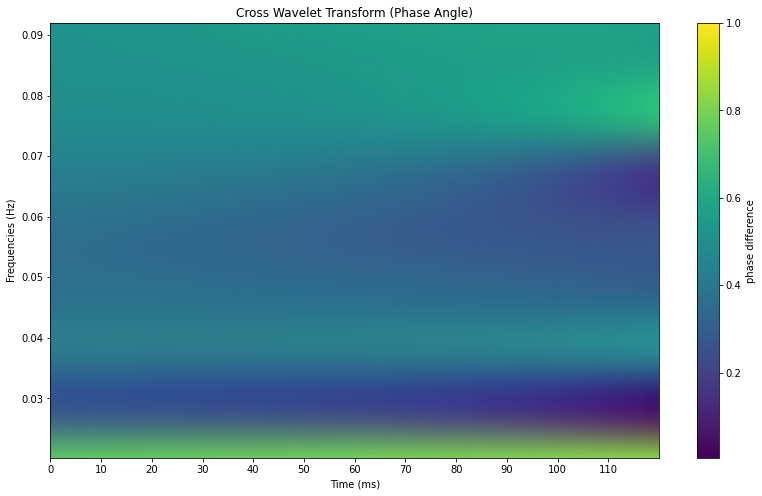

In [16]:
plot_xwt_phase_angle(epo_1, epo_2, sfreq= 7.8125, freqs = np.arange(2, 12)/100., time=120,
                        time_conv = 1, xmin = 0, x_units = 10, y_units = 0.01)